In [1]:
import sys
sys.path.append("../src")

In [2]:
%load_ext autoreload
%autoreload 2
from util import *
import util
from visualization import *
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from model import build_food101_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# DATA EXPLORATION

In [3]:
df = get_df() 
get_df_stats(df)

,num_samples,num_classes,samples_per_class,splits
0,101000,101,"{'apple_pie': 1000, 'baby_back_ribs': 1000, 'b...","{'train': 75750, 'test': 25250}"


In [4]:
df.sample(5)

,class_name,file_id,path,split
42928,hummus,1939279,s:\Machine Learning\food-classification\data\i...,train
7864,bruschetta,2772698,s:\Machine Learning\food-classification\data\i...,train
29921,foie_gras,576688,s:\Machine Learning\food-classification\data\i...,train
78877,cannoli,271470,s:\Machine Learning\food-classification\data\i...,test
51053,onion_rings,123878,s:\Machine Learning\food-classification\data\i...,train


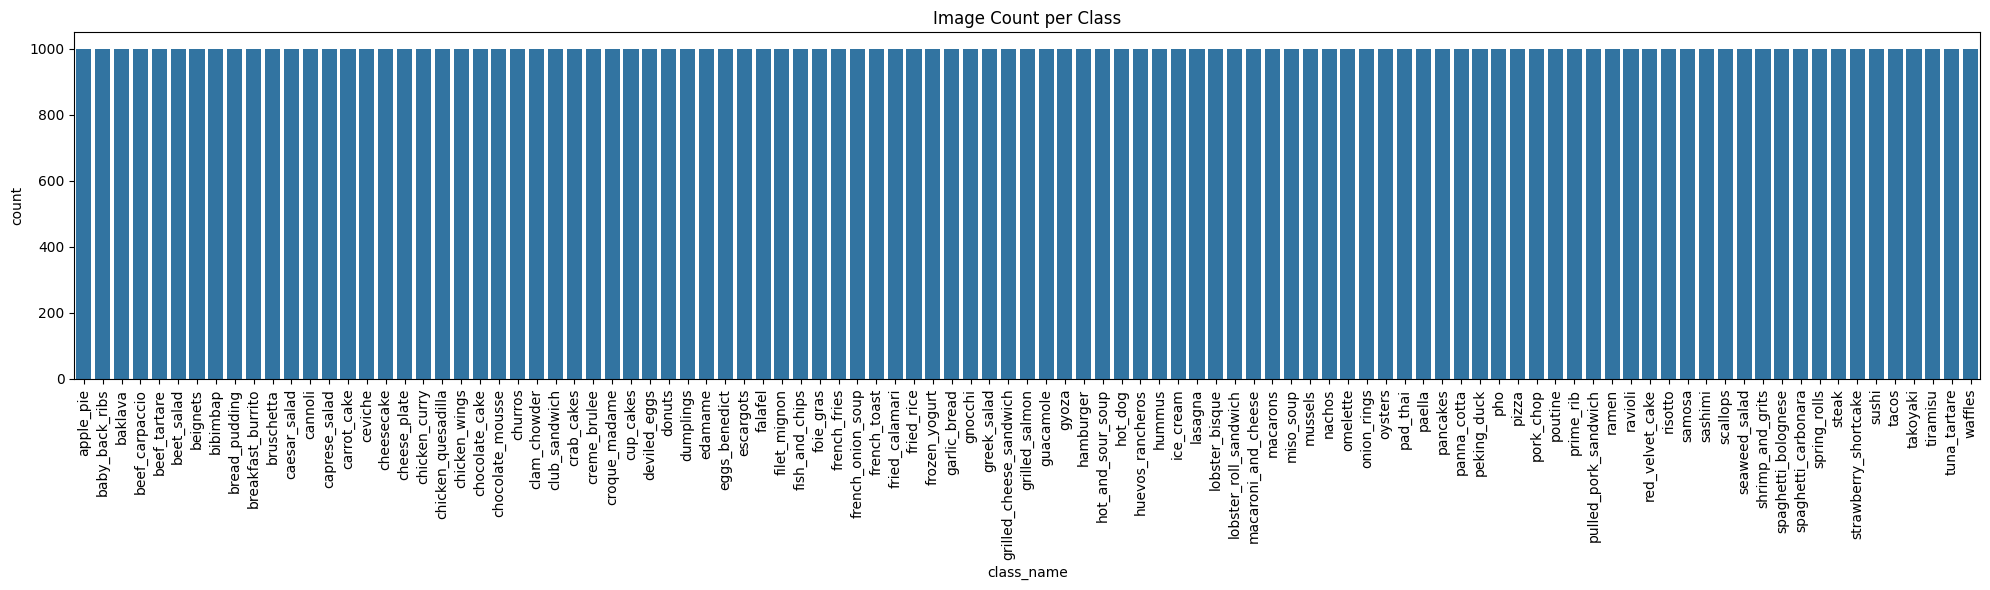

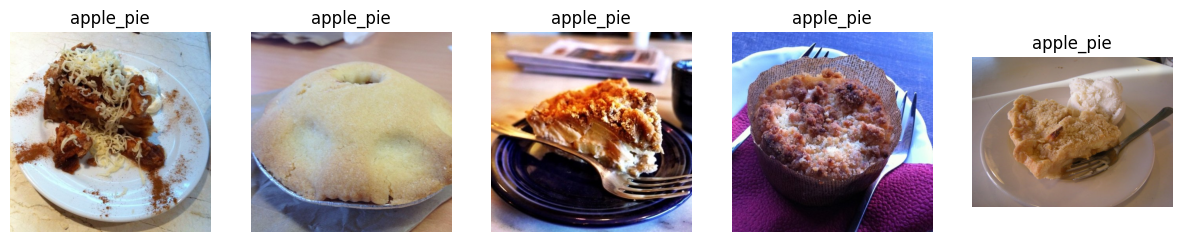

In [5]:
show_class_distribution(df)
show_sample_images(df, "apple_pie", 5)

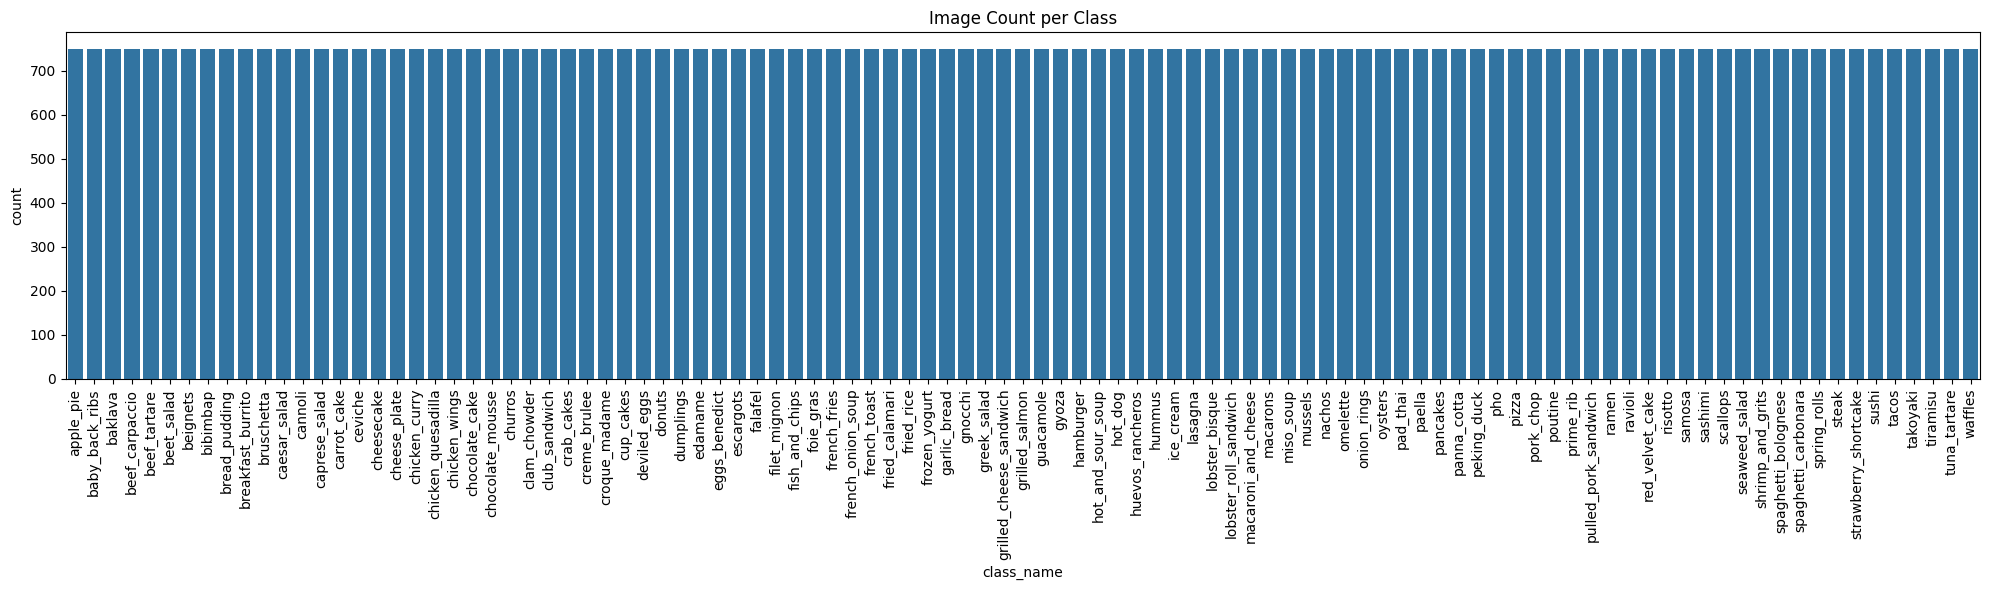

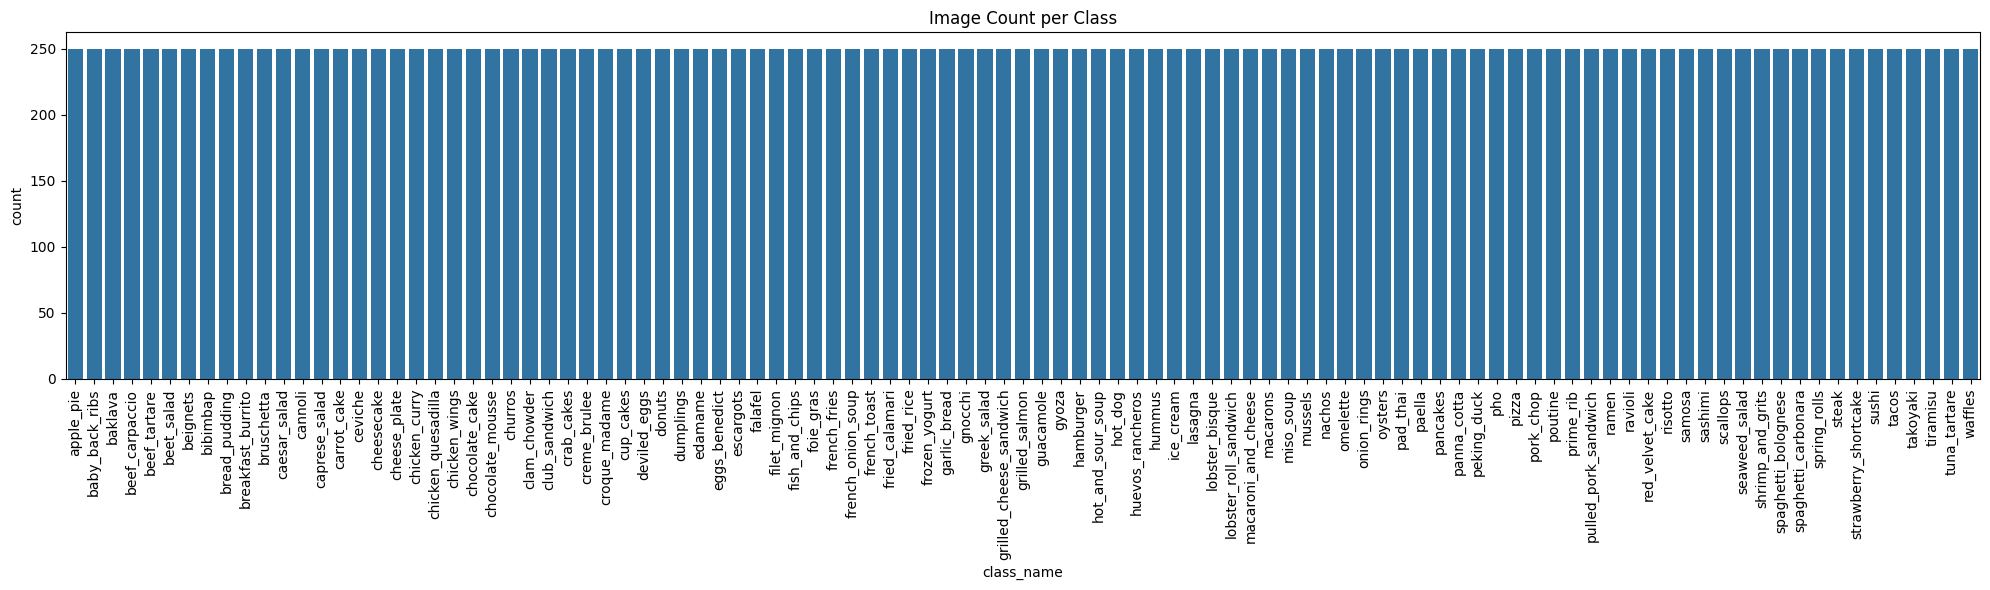

In [6]:
show_class_distribution(df[df['split'] == 'train'])
show_class_distribution(df[df['split'] == 'test'])

# DATA PROCESSING


In [7]:
train_df, test_df = get_data_generators(df)

Found 75750 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


# CREATE MODEL


In [ ]:
MODEL_PATH = "food101_mobilenetv2.keras"

num_classes = len(df['class_name'].unique())
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("food101_mobilenetv2.keras", save_best_only=True)

if os.path.exists(MODEL_PATH):
    print("Loading existing model...")
    model = load_model(MODEL_PATH)
    _, base_model = build_food101_model(num_classes)
else:
    print("Building new model...")
    model, base_model = build_food101_model(num_classes)

    # Callbacks

    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Initial training (base_model is frozen)
    history = model.fit(
        train_df,
        epochs=10,
        validation_data=test_df,
        callbacks=[early_stop, checkpoint]
    )
    plot_history(history, "fit tune history")
    model.save(MODEL_PATH)

Loading existing model...


In [ ]:
FINE_TUNE_MODEL_PATH = "food101_mobilenetv2_finetuned.keras"

if os.path.exists(FINE_TUNE_MODEL_PATH):
    print("Loading fine-tuned model...")
    model = load_model(FINE_TUNE_MODEL_PATH)
else:
    print("Fine-tuning model...")

    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False

    # Compile with a lower learning rate for fine-tuning
    from tensorflow.keras.optimizers import Adam
    model.compile(
        optimizer=Adam(learning_rate=1e-5),  # Lower LR to avoid ruining pre-trained weights
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune
    fine_tune_history = model.fit(
        train_df,
        epochs=10,
        validation_data=test_df,
        callbacks=[early_stop, checkpoint]
    )
    plot_history(history, "fine tune history")
    model.save(FINE_TUNE_MODEL_PATH)

Loading fine-tuned model...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
31


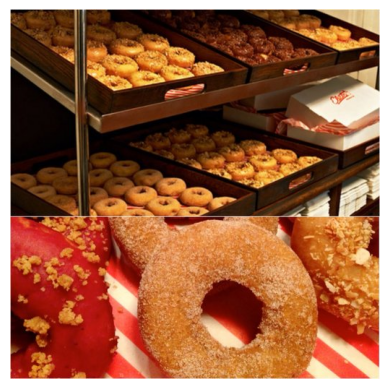

In [49]:
image = get_random_image_from_class(df, "donuts")
print(model_predict(model,image))
display_image(image)